In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
from cartopy import crs as ccrs, feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import xarray as xr
from netCDF4 import Dataset
from scipy.interpolate import griddata
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import os


In [19]:
YES = 1
NO = 0

In [20]:
import math as m

def get_distance(lat1, lat2, lon1, lon2, R):
    """Calculate distance between start and end points using Harvesin formula
    Result in meters (m)!"""
    # Convert lat and lon to radians for the formula
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    a = np.power(np.sin((lat2-lat1) / 2), 2) + np.cos(lat1) * np.cos(lat2) * np.power(np.sin((lon2-lon1) / 2), 2)
    distance = 2 * R * np.arcsin(np.sqrt(a))
    return distance * 1000

def get_angle(point1, point2):
    """ Get angle (in radians) of segment of line with respect to x-axis"""
    y2 = point2[1]
    x2 = point2[0]
    y1 = point1[1]
    x1 = point1[0]

    if x1 == x2:
        theta = m.pi/2 if y2 > y1 else -m.pi/2  # 0 degrees for North, -180 for South
    else:
        slope = (y2-y1)/(x2-x1)
        theta = np.arctan(slope)

    return theta

def get_velocity (u, v, theta):
    """ Compute the velocity based on u (x-axis) and v (y-axis) velocities and the angle theta (relative to x-axis)"""
    return u*np.sin(theta) + v*np.cos(theta)



def find_angle_variations(lats, lons, a):
    """Computes the angle between two consecutive stations and detects angles above a degrees.
       Stores the coordinates where these variations are detected. """
    
    thetas = []
    borders_idx = []
    borders_idx.append(0)

    if len(lats) != len(lons):
        print("Lats and lons should have same dimensions.")
        return None, None
    
    for i in range(len(lats) - 1):
        lat1, lon1 = lats[i], lons[i]
        lat2, lon2 = lats[i + 1], lons[i + 1]
        
        angle = get_angle([lon1, lat1], [lon2, lat2])
            
        if len(thetas) > 0 and abs(angle - thetas[-1]) > np.radians(a):
            borders_idx.append(i)

        thetas.append(angle)

    borders_idx = [borders_idx[0]] + [borders_idx[j] for j in range(1, len(borders_idx)) if (borders_idx[j] - borders_idx[j-1]) > 2]
    borders_idx.append(i+1)

    return thetas, borders_idx



In [21]:
a = get_angle([0,0], [1,1])
np.degrees(a)

np.float64(45.0)

In [22]:
class Transect:
    def __init__(self, lat1, lat2, lon1, lon2, i, month, year) -> None:

        self.label = i
        self.month = month
        self.year = year
        self.theta = get_angle([lon1,lat1], [lon2,lat2])
        self.distance = get_distance(lat1, lat2, lon1, lon2, 6371)
        self.lat1 = lat1
        self.lat2 = lat2
        self.lon1 = lon1
        self.lon2 = lon2
        self.lats = []
        self.lons = []
        self.depths = []
        self.distances = []

        self.velocities = []
        self.data_points = []
        self.grid_points = []

class TransectInfo:
    def __init__(self, lat1, lat2, lon1, lon2, i, params) -> None:

        self.label = i
        self.theta = get_angle([lon1,lat1], [lon2,lat2])
        self.distance = get_distance(lat1, lat2, lon1, lon2, 6371)
        self.lat1 = lat1
        self.lat2 = lat2
        self.lon1 = lon1
        self.lon2 = lon2
        self.lats = []
        self.lons = []
        self.depths = []
        self.distances = []

        self.grid_points = []
        self.params = params
        
        self.num_cells_x = int(np.ceil(self.distance / self.params['delta_distance'])) if self.params['delta_distance'] < self.distance else 1
        self.num_cells_z = int(np.ceil((self.params['max_depth'] - self.params['min_depth']) / self.params['delta_depth'])) if self.params['delta_depth'] < self.params['max_depth'] else 1

    def print_info(self):
        
        print(f"Transect no.{self.label}")
        print(f"Angle theta = {np.degrees(self.theta)}")
        print(f"Total distance d = {self.distance} m")
    
        print(f"Initial coordinates: ({self.lat1}, {self.lon1})")
        print(f"Final coordinates: ({self.lat2}, {self.lon2})")


### Data

In [23]:
file_path = 'data/HD_Monthly_Data_19932020.nc'
data = xr.open_dataset(file_path)
data

<xarray.Dataset> Size: 53GB
Dimensions:    (depth: 40, latitude: 265, longitude: 457, time: 336)
Coordinates:
  * depth      (depth) float32 160B 0.494 1.541 2.646 ... 1.684e+03 1.942e+03
  * latitude   (latitude) float32 1kB 44.0 44.08 44.17 ... 65.83 65.92 66.0
  * longitude  (longitude) float32 2kB -30.0 -29.92 -29.83 ... 7.833 7.917 8.0
  * time       (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2020-12-01
Data variables:
    so         (time, depth, latitude, longitude) float64 13GB ...
    thetao     (time, depth, latitude, longitude) float64 13GB ...
    bottomT    (time, latitude, longitude) float64 326MB ...
    uo         (time, depth, latitude, longitude) float64 13GB ...
    vo         (time, depth, latitude, longitude) float64 13GB ...
    mlotst     (time, latitude, longitude) float64 326MB ...
    zos        (time, latitude, longitude) float64 326MB ...
Attributes: (12/15)
    Conventions:                       CF-1.6
    area:                              GLOBAL
    contact:                           servicedesk.cmems@mercator-ocean.eu
    credit:                            E.U. Copernicus Marine Service Informa...
    dataset:                           global-reanalysis-001-030-monthly
    institution:                       Mercator Ocean
    ...                                ...
    product_user_manual:               http://marine.copernicus.eu/documents/...
    quality_information_document:      http://marine.copernicus.eu/documents/...
    references:                        http://marine.copernicus.eu
    source:                            MERCATOR GLORYS12V1
    title:                             Monthly mean fields for product GLOBAL...
    copernicus_marine_client_version:  0.10.7

In [24]:
stations_df = pd.read_excel('data/Ellet_Stations.xlsx')[:36]
stations_df

,Station,Latitude,Longitude,Nominal.Depth.(m),Unnamed: 4
0,IG,56.667,-6.133,190,0
1,2G,56.683,-6.283,30,1
2,3G,56.708,-6.367,70,2
3,4G,56.733,-6.450,115,3
4,5G,56.733,-6.600,80,4
5,6G,56.733,-6.750,40,5
6,7G,56.733,-7.000,140,6
7,8G,56.733,-7.167,170,7
8,9G,56.733,-7.333,160,8
9,IOG,56.733,-7.500,215,9


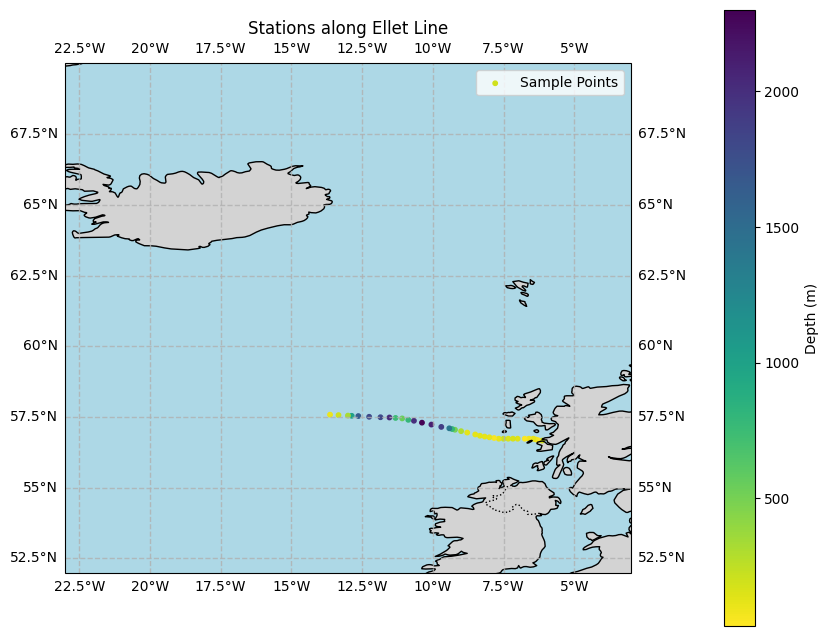

In [25]:
# Visualize the samples position and the transect

projection = ccrs.PlateCarree()
plt.figure(figsize=(10,8))
ax = plt.axes(projection=projection)
ax.set_extent([-23, -3, 52, 70], crs=projection)  

# Plot the data points
scatter = plt.scatter(stations_df['Longitude'], stations_df['Latitude'], c=stations_df['Nominal.Depth.(m)'], cmap='viridis_r', s=10, transform=ccrs.PlateCarree(), label='Sample Points')

cbar = plt.colorbar(scatter, label='Depth', orientation='vertical', pad=0.12)
cbar.set_label('Depth (m)')

# Customize the plot
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.xaxis.set_major_formatter(LongitudeFormatter())  
ax.yaxis.set_major_formatter(LatitudeFormatter())  

gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=1, alpha=0.8)

plt.legend()
plt.title('Stations along Ellet Line')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Analysis of the transport in one specific month

### 1. Decide transect and analyse it: you might need to divide it into smaller transects. Filter the relevant data and interpolate the variables of interest along the transect


##### 1.1. Determine slopes between consequtive points and detect angle variations (might imply subtransects within transect)

In [26]:
# # Compute angle between consecutive stations to inspect significant variations in angle throughout the transect
# # Divide transect into "subtransects" with a similar theta angle among them, store coordinates when there is a significant variation in angle,
# # and store the angle at each point.
# thetas, borders_idx = find_angle_variations(stations_df['Latitude'], stations_df['Longitude'], 10)
# borders_idx

##### 1.2. For each subtransect, create a regular grid and interpolate the variables of interest along it

In [27]:
def get_transect_grid(lat1, lat2, lon1, lon2, i, params):
    transect = TransectInfo(lat1, lat2, lon1, lon2, i, params)

    # Create a regular grid of coordinates over the transect, and use the depths from GLORYS
    # But we also need the depth and coordinates at center of each cell to get the variables of interest at the center of each cell 
    transect.depths = np.linspace(params['min_depth'], params['max_depth'], transect.num_cells_z + 1)
    transect.lats = np.linspace(lat1, lat2, transect.num_cells_x + 1)
    transect.lons = np.linspace(lon1, lon2, transect.num_cells_x + 1)

    mid_depths = (transect.depths[:-1] + transect.depths[1:]) / 2
    mid_lats = (transect.lats[:-1] + transect.lats[1:]) / 2
    mid_lons = (transect.lons[:-1] + transect.lons[1:]) / 2 

    points_lat_lon = np.column_stack((mid_lats, mid_lons))
    transect.grid_points = []
    for (lat, lon) in points_lat_lon:
        for depth in mid_depths:
            transect.grid_points.append((lat, lon, depth))

    # We need a fictional axis that goes along the transect for when calculating the flow
    transect.distances = [
        get_distance(lat1, transect.lats[j], lon1, transect.lons[j], 6371)
        for j in range(transect.num_cells_x + 1)
    ]
    
    return transect


def generate_transect_values(month, year, data, info, method):
    ''' Prepares the necessary data and fills the values of all variables:
    - Latitude, Longitude and Depth grid
    - Mid Latitude, Longitude and Depth of each grid cell'''
    
    # method = 'nearest'
    lat1 = info.lat1
    lat2 = info.lat2
    lon1 = info.lon1
    lon2 = info.lon2

    transect = Transect(lat1, lat2, lon1, lon2, info.label, month, year)

    # Prepare data from GLORYS to use for the interpolation
    # Filter the original dataset used for the interpolation to reduce computational cost (both time and memory)
    df_transect = data[(data['latitude'] >= min(lat1,lat2) - 0.080000) & (data['latitude'] <= max(lat1,lat2) + 0.080000) 
                     & (data['longitude'] >= min(lon1,lon2) - 0.080000000) & (data['longitude'] <= max(lon1,lon2) + 0.080000000)]
    
    df_transect = df_transect.sample(n=min(int(10/100 * len(df_transect)), len(df_transect)), random_state=123)
    data_points = df_transect[['latitude', 'longitude', 'depth']]
 
    ## In case you want to store more data for further analysis : WARNING: IT WILL INCREASE RUNNING TIME
    print("Starting interpolations...")
    # transect.temps = griddata(data_points.values, df_transect['thetao'], info.grid_points, method=method)
    # transect.sals = griddata(data_points.values, df_transect['so'], info.grid_points, method=method)
   
    uos = griddata(data_points.values, df_transect['uo'], info.grid_points, method=method)
    vos = griddata(data_points.values, df_transect['vo'], info.grid_points, method=method)
    velocities = get_velocity(uos, vos, info.theta)

    return velocities



### Plots for analysis of one flow calculation

In [28]:
# min_lon, max_lon, min_lat, max_lat = -23, -3, 52, 70

def format_lon_label(x):
    return f"{abs(x):.1f}°{'W' if x < 0 else 'E'}"

def format_lat_label(y):
    return f"{abs(y):.1f}°{'S' if y < 0 else 'N'}"

#### STATIONS & TRANSECTS & ANGLES
def plot_stations_in_map(c_a, c_st, stations, thetas, trans_idx, subtransects):
    ''' Plots stations in the map with optional angles relative to longitude axis as color of the station point, 
    and optional regularly spaced transects on top.
     To enable these features, first two input variables must be YES. '''

    projection = ccrs.PlateCarree()
    plt.figure(figsize=(10,8))
    ax = plt.axes(projection=projection)
    ax.set_extent([-23, -3, 52, 70], crs=projection)

    # Customize the plot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.xaxis.set_major_formatter(LongitudeFormatter())  
    ax.yaxis.set_major_formatter(LatitudeFormatter())  
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=1, alpha=0.8)

    if c_a == YES:
        thetas_t = thetas.copy()  
        thetas_t.append(0)
        color = c=np.degrees(thetas_t)
    else:
        color = 'black'
    scatter = plt.scatter(stations['Longitude'], stations['Latitude'], c=color, 
                              s=50, transform=ccrs.PlateCarree(), edgecolor='black')
    
    if c_a == YES:
        cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.1)
        cbar.set_label('Theta (degrees)', fontsize=12)
        cbar.set_ticks(np.arange(-90, 91, 30))  # Adjust ticks as necessary

    if c_st == YES:
        for i in range(0, len(trans_idx)-1):
            plt.plot(subtransects[i].lons, subtransects[i].lats, c='red', transform=ccrs.PlateCarree(), linewidth=3)

        plt.plot([],[], c='red', label='Subtransects', linewidth=3) 
    plt.scatter([],[], c='black', label='Ellet Line stations', s=20, edgecolor='black')
    # plt.plot([],[], c='darkred', label='Transition between transects', linewidth=3)

    plt.title('Stations along transect')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

####


#### DATA USED
def plot_data_used(stations, subtransects, trans_idx):
    '''Plots in the map all the data used, including stations / coordinates of transect, 
    coordinates of data points and "fake" transects used for interpolation. '''

    projection = ccrs.PlateCarree()
    plt.figure(figsize=(10,10))

    ax = plt.axes(projection=projection)
    ax.set_extent([-23, -3, 52, 70], crs=projection)  
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.xaxis.set_major_formatter(LongitudeFormatter())  
    ax.yaxis.set_major_formatter(LatitudeFormatter())  
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=1, alpha=0.8)

    for i in range(0, len(trans_idx)-1):
        plt.scatter(subtransects[i].data_points['longitude'], subtransects[i].data_points['latitude'], c='orange', s=2, transform=ccrs.PlateCarree())
    plt.scatter(stations['Longitude'], stations['Latitude'], c='black', s=20, transform=ccrs.PlateCarree(), edgecolor='black')
    for i in range(0, len(trans_idx)-1):
        plt.scatter(subtransects[i].lons, subtransects[i].lats, c='white', s=20, transform=ccrs.PlateCarree(), edgecolor='black')

    plt.scatter(1,1, c='black', label='Ellet Line stations', s=20, edgecolor='black')
    plt.scatter(1,1, c='orange', label='GLORYS data', s=20) 
    plt.scatter(1,1, c='white', label='Regularly spaced transects', s=20, edgecolor='black')

    plt.title('Spatial distribution of data used: Ellet Line, GLORYS data, interpolated transect')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()
####

#### VELOCITIES MAGNITUDES
def plot_variable_in_3D(dir_or_mag, variable, transectsInfo, variable_name):
    '''Plot in 3D the velocities accross the transect. Another function does the same for flows.
    An option is also given between presenting the magnitude of the values or only the signal.'''

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    if variable_name == 'velocity':
        units = 'm/s'
        title = 'Velocity over the Transect'
        labelv = 'Velocity (m/s)'

    elif variable_name == 'temperature':
        units = 'degrees Celcius'
        title = 'Temperature over the Transect'
        labelv = 'Temperature (degrees Celcius)'

    if variable_name == 'salinity':
        units = 'PSU'
        title = 'Salinity over the Transect'
        labelv = 'Salinity (PSU)'
    
    
    # Find global min and max across all transects
    minv, maxv = float('inf'), float('-inf')

    minv = min(np.nanmin(variable), minv)
    maxv = max(np.nanmax(variable), maxv)
    cbar_limit = max(abs(minv), abs(maxv))

    # Color bar
    colors = ["red", "yellow", "green"]
    cmap_name = "custom_vivid"
    cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
    cmap.set_bad(color='grey')  # NaN values as grey

    # Plot each transect with the same color scale

    grid_lats, grid_lons, grid_depths = zip(*transectsInfo.grid_points)

    if variable_name == 'velocity' and dir_or_mag == 'magnitude':
        sc = ax.scatter(grid_lons, grid_lats, grid_depths, c=variable, 
                    cmap=cmap, s=50, vmin=-cbar_limit, vmax=cbar_limit, 
                    label='Data Points')
        
        cbar = fig.colorbar(sc, ax=ax, orientation='vertical')
        cbar.set_label({labelv})
        cbar.set_ticks([minv, 0, maxv])

    elif variable_name == 'velocity' and dir_or_mag == 'direction':
        # sizes = np.clip((np.abs(transect.velocities) / maxv) * 50, 0, 50)
        colors = ['red' if v < 0 else 'green' if v > 0 else 'white' for v in variable]
        sc = ax.scatter(grid_lons, grid_lats, grid_depths, c=colors, s=50)

        ax.scatter([], [], [], c='green', label='Positive Points')
        ax.scatter([], [], [], c='red', label='Negative Points')

    
    elif variable_name == 'temperature' or variable_name == 'salinity':
        sc = ax.scatter(grid_lons, grid_lats, grid_depths, c=variable, 
                    cmap=cmap, s=50, vmin=minv, vmax=maxv, 
                    label='Data Points')
        
        cbar = fig.colorbar(sc, ax=ax, orientation='vertical')
        cbar.set_label(labelv)
        cbar.set_ticks(np.linspace(minv, maxv, 5))


    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth')
    ax.invert_zaxis() 
    ax.view_init(elev=45, azim=-120)
    ax.xaxis.set_major_formatter(LongitudeFormatter())  
    ax.yaxis.set_major_formatter(LatitudeFormatter())  
    ax.legend()

    plt.title(f"Velocity along Transect {title}")
    plt.show()
#####


In [29]:
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib import animation


def plot_variable_in_3D_animation(dir_or_mag, trans_idx, subtransects_by_month):
    """
    Create an animated 3D plot showing the evolution of velocities across a transect over the year.
    Parameters:
    - dir_or_mag: 'magnitude' or 'direction' to indicate the type of plot.
    - trans_idx: list of indices for the transect divisions.
    - subtransects_by_month: list of subtransects for each month of the year (length 12).
    """
    
    # Set up figure and 3D axis
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Determine global color limits if plotting magnitudes
    if dir_or_mag == 'magnitude':
        minv, maxv = float('inf'), float('-inf')
        for transects_ in subtransects_by_month:
            for i in range(len(trans_idx) - 1):
                transect = transects_[i]
                minv = min(np.nanmin(transect.velocities), minv)
                maxv = max(np.nanmax(transect.velocities), maxv)
        cbar_limit = max(abs(minv), abs(maxv))
        colors = ["red", "yellow", "green"]
        cmap_name = "custom_vivid"
        cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
        cmap.set_bad(color='grey')  # NaN values as grey
    
    # Initialize scatter plot variable
    scatter = None

    def update_plot(month_idx):
        """Update function for the animation."""
        nonlocal scatter
        ax.clear()  # Clear previous data
        
        month_data = subtransects_by_month[month_idx]
        
        # Plot each transect with the updated monthly data
        for i in range(len(trans_idx) - 1):
            transect = month_data[i]
            grid_lats, grid_lons, grid_depths = zip(*transect.grid_points)
            
            if dir_or_mag == 'magnitude':
                scatter = ax.scatter(
                    grid_lons, grid_lats, grid_depths,
                    c=transect.velocities, cmap=cmap, s=50,
                    vmin=-cbar_limit, vmax=cbar_limit
                )
                
            elif dir_or_mag == 'direction':
                colors = ['red' if v < 0 else 'green' if v > 0 else 'white' for v in transect.velocities]
                scatter = ax.scatter(grid_lons, grid_lats, grid_depths, c=colors, s=50)

        # Set axis labels and invert depth axis
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_zlabel('Depth')
        ax.invert_zaxis()
        ax.set_title(f"Velocity along Transect (Month {month_idx + 1})")

        # Set colorbar if plotting magnitude
        if dir_or_mag == 'magnitude':
            cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
            cbar.set_label('Velocity (m/s)')
            cbar.set_ticks([-cbar_limit, 0, cbar_limit])
        elif dir_or_mag == 'direction':
            ax.scatter([], [], [], c='green', label='Positive Points')
            ax.scatter([], [], [], c='red', label='Negative Points')
        
        # Add legend and formatting
        ax.legend()
        ax.view_init(elev=45, azim=-120)
    
    # Create animation
    anim = FuncAnimation(
        fig, update_plot, frames=range(0,11,1),  # 12 frames for 12 months
        interval=500,  # Interval in milliseconds
        repeat=True
    )

    # Display the animation
    plt.show()

    # Optionally, save the animation as a GIF or MP4
    anim.save("velocity_evolution.gif", writer="imagemagick", fps=2)
    # anim.save("velocity_evolution.mp4", writer="ffmpeg", fps=2)

# Usage example assuming subtransects_by_month is a list of lists where each list has the transects for that month
# plot_variable_in_3D_animation('magnitude', trans_idx, subtransects_by_month)

### 2. Calculate the flux through the transect

In [30]:
def calculate_flux(distances, depths, velocities):
    ''' Calculates the transport through a grid with known velocity values.
    All values should be in meters (m) !'''
    # print("Calculating flux")
    Q = 0.0
    A = 0.0
    diffs_x = np.abs(np.diff(np.array(distances)))
    diffs_z = np.abs(np.diff(depths)) 

    # Check if velocities can be reshaped to the desired shape
    if velocities.size == len(diffs_z) * len(diffs_x):
        # Check if the shape matches, if not, reshape
        if velocities.shape[0] != len(diffs_z) or velocities.shape[1] != len(diffs_x): 
            velocities = velocities.reshape(len(diffs_z), len(diffs_x))
    else:
        raise ValueError("Cannot reshape velocities to shape ({}, {}). Dimensions do not match.".format(len(diffs_z), len(diffs_x)))


    for i in range(len(diffs_z)):  
        for j in range(len(diffs_x)): 
            if not np.isnan(velocities[i,j]):
                A += diffs_z[i] * diffs_x[j]
                Q += diffs_z[i] * diffs_x[j] * velocities[i,j]
    
    print("Flux calculated!")

    return Q, A



### 3. Calculate Flow for all data

In [31]:
params = {
            'delta_distance': 25000, # m
            'delta_depth': 50, # m
            'max_depth': 300, # m
            'min_depth': 0, # m
            'precision': 5 # decimal points
        }

transectsInfo = get_transect_grid(stations_df['Latitude'].min(), stations_df['Latitude'].max(), 
                                  stations_df['Longitude'].min(), stations_df['Longitude'].max(), 0, params)

In [32]:
# thetas, borders_idx = find_angle_variations(stations_df['Latitude'], stations_df['Longitude'], 10)

flow_df = pd.DataFrame(columns=['Year', 'Month', 'Area', 'Flow'])
years = pd.to_datetime(data.time).year.unique()


method = 'linear'

vel_per_year = []
years = [1993]
for year in years:

    # Selecting data for analysing that year
    data_year = data.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    months = pd.to_datetime(data.time).month.unique()

    vel_by_month = []
    # months = [1]
    for month in months:

        data_month = data.sel(time=slice(f"{year}-{month}-01", f"{year}-{month}-28"))

        df = data_month.to_dataframe().reset_index()
        variables = ['so', 'thetao', 'uo', 'vo']
        df = df[['depth', 'latitude', 'longitude', 'time', 'so', 'thetao', 'uo', 'vo']].dropna(subset = variables)

        ######
        velocities = generate_transect_values(month, year, df, transectsInfo, method)
        # Calculate flux in the subtransect
        Q = 0.0
        A = 0.0
        Q_transect, A_transect = calculate_flux(transectsInfo.distances, transectsInfo.depths, velocities)
        Q += (Q_transect /1000000)
        A += (A_transect /1000000)
        #####
            
        print(f"Date: {month}/{year}")
        print(f"total Q = {np.round(Q, 4)} Sv")
        print(f"total A = {np.round(A, 4)} km2")
        flow_df.loc[len(flow_df)] = [year, month, A, Q]

        vel_by_month.append(velocities)

    vel_per_year.append(vel_by_month)    
    
flow_df

Starting interpolations...
Flux calculated!
Date: 1/1993
total Q = 8.4948 Sv
total A = 135.4997 km2
Starting interpolations...
Flux calculated!
Date: 2/1993
total Q = 4.784 Sv
total A = 135.4997 km2
Starting interpolations...
Flux calculated!
Date: 3/1993
total Q = 3.8822 Sv
total A = 135.4997 km2
Starting interpolations...
Flux calculated!
Date: 4/1993
total Q = 3.4723 Sv
total A = 135.4997 km2
Starting interpolations...
Flux calculated!
Date: 5/1993
total Q = 3.3993 Sv
total A = 135.4997 km2
Starting interpolations...
Flux calculated!
Date: 6/1993
total Q = 4.7552 Sv
total A = 135.4997 km2
Starting interpolations...
Flux calculated!
Date: 7/1993
total Q = 3.5429 Sv
total A = 135.4997 km2
Starting interpolations...
Flux calculated!
Date: 8/1993
total Q = 3.6813 Sv
total A = 135.4997 km2
Starting interpolations...
Flux calculated!
Date: 9/1993
total Q = 4.0744 Sv
total A = 135.4997 km2
Starting interpolations...
Flux calculated!
Date: 10/1993
total Q = 4.4359 Sv
total A = 135.4997 km2


,Year,Month,Area,Flow
0,1993.0,1.0,135.499693,8.494809
1,1993.0,2.0,135.499693,4.783994
2,1993.0,3.0,135.499693,3.882195
3,1993.0,4.0,135.499693,3.472266
4,1993.0,5.0,135.499693,3.399292
5,1993.0,6.0,135.499693,4.755181
6,1993.0,7.0,135.499693,3.542944
7,1993.0,8.0,135.499693,3.681286
8,1993.0,9.0,135.499693,4.074408
9,1993.0,10.0,135.499693,4.435887


In [33]:
# num_nan = np.isnan(transect.velocities).sum()

# print("Number of NaN values:", num_nan)
# # transect.velocities

In [34]:
flow_df

,Year,Month,Area,Flow
0,1993.0,1.0,135.499693,8.494809
1,1993.0,2.0,135.499693,4.783994
2,1993.0,3.0,135.499693,3.882195
3,1993.0,4.0,135.499693,3.472266
4,1993.0,5.0,135.499693,3.399292
5,1993.0,6.0,135.499693,4.755181
6,1993.0,7.0,135.499693,3.542944
7,1993.0,8.0,135.499693,3.681286
8,1993.0,9.0,135.499693,4.074408
9,1993.0,10.0,135.499693,4.435887


In [35]:
# # Calculate differences
# diffs_temps = np.diff(transect.temps)

# # Remove NaN values
# diffs_temps_no_nan = diffs_temps[~np.isnan(diffs_temps)]

# # Find the index of the maximum absolute difference
# max_diff_index = np.argmax(np.abs(diffs_temps_no_nan))

# # Alternatively, if you want the index in the original `diffs_temps` with NaNs,
# # use this to get the non-NaN positions:
# non_nan_indices = np.where(~np.isnan(diffs_temps))[0]
# original_index = non_nan_indices[max_diff_index]

# print("Original index in `transect.temps`:", original_index)

In [36]:
# transects_by_month[0].temps

In [37]:
# plot_variable_in_3D('magnitude', transect.temps, transectsInfo, 'temperature')

In [38]:
# plot_variable_in_3D('magnitude', transect.velocities, transectsInfo, 'velocity')

In [39]:
anualflow_df = pd.DataFrame(columns=['Year', 'Flow'])

flow_df['date'] = pd.to_datetime(flow_df[['Year', 'Month']].assign(day=1))
flow_df['Year'] = flow_df['date'].dt.year
flow_df['Month'] = flow_df['date'].dt.month

for year in flow_df['Year'].unique():
    Qanual_mean = np.mean(flow_df[(flow_df['Year']==year)]['Flow'])

    anualflow_df.loc[len(anualflow_df)] = [year, Qanual_mean]


anualflow_df


,Year,Flow
0,1993.0,4.425956


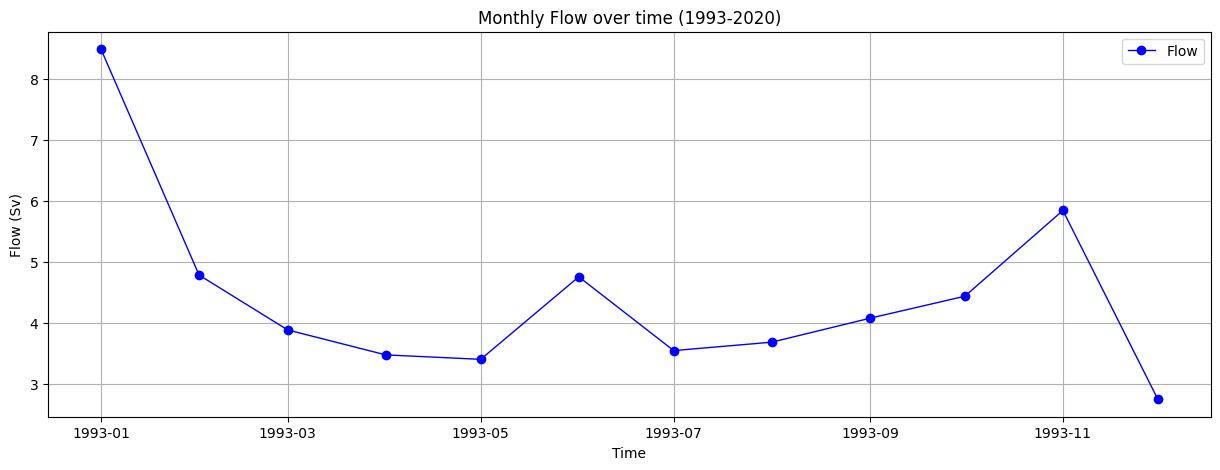

In [40]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(flow_df['date'], flow_df['Flow'], marker='o', color='b', linewidth=1, label='Flow')
# plt.axhline(y=0, color='red', linestyle='-', lable)

flow_df = flow_df.drop(columns={'date'})
# Labels and title
plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Monthly Flow over time (1993-2020)')

# Ensure all x-tick labels are displayed
# plt.xticks(flow_df['date'])  # Display all tick labels for x-axis
plt.grid()
# Legend
plt.legend()

# Show plot
plt.show()


In [41]:
flow_df

,Year,Month,Area,Flow
0,1993,1,135.499693,8.494809
1,1993,2,135.499693,4.783994
2,1993,3,135.499693,3.882195
3,1993,4,135.499693,3.472266
4,1993,5,135.499693,3.399292
5,1993,6,135.499693,4.755181
6,1993,7,135.499693,3.542944
7,1993,8,135.499693,3.681286
8,1993,9,135.499693,4.074408
9,1993,10,135.499693,4.435887


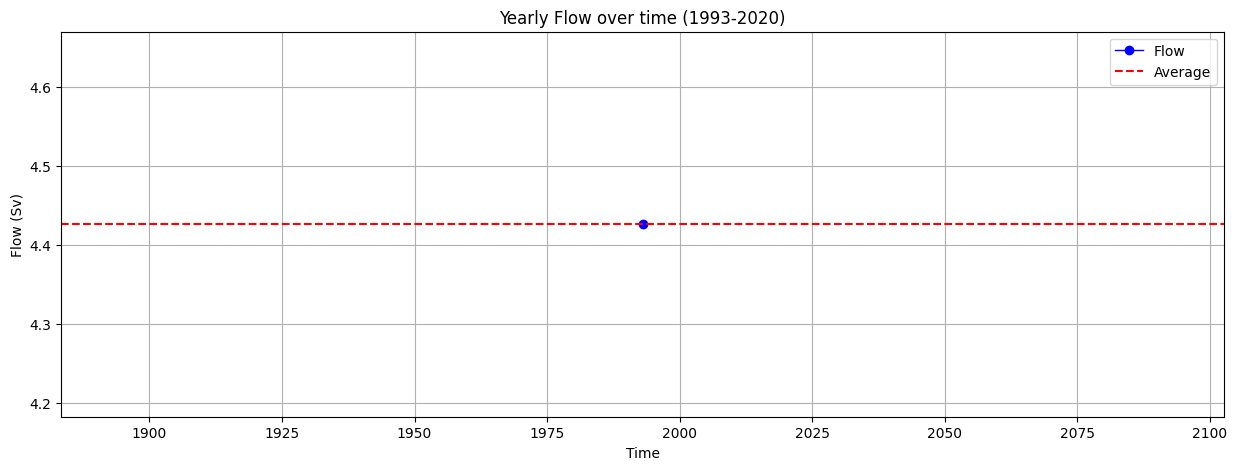

In [42]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(anualflow_df['Year'], anualflow_df['Flow'], marker='o', color='b', linewidth=1, label='Flow')
plt.axhline(y=np.mean(anualflow_df['Flow']), color='red', linestyle='--', label='Average')


# Labels and title
plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Yearly Flow over time (1993-2020)')

# Ensure all x-tick labels are displayed
# plt.xticks(flow_df['date'])  # Display all tick labels for x-axis
plt.grid()
# Legend
plt.legend()

# Show plot
plt.show()


### Save to Excel file

In [43]:
file_path = 'data/Transport_1993_2020.xlsx'

# Check if the file exists
if os.path.exists(file_path):
    with pd.ExcelWriter('data/Transport_1993_2020.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        flow_df.to_excel(writer, sheet_name='Ellet Line (M)', index=False)
        anualflow_df.to_excel(writer, sheet_name='Ellet Line (Y)', index=False)
else:
    with pd.ExcelWriter('data/Transport_1993_2020.xlsx', engine='openpyxl') as writer:
        flow_df.to_excel(writer, sheet_name='Ellet Line (M)', index=False)
        anualflow_df.to_excel(writer, sheet_name='Ellet Line (Y)', index=False)


PermissionError: [Errno 13] Permission denied: 'data/Transport_1993_2020.xlsx'